# Sequential Composition Demo

Trying to see if sequential composition is viable.

## Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from os.path import dirname

In [2]:
note_dir = os.getcwd()
root_dir = dirname(note_dir)
data_dir = os.path.join(root_dir, 'resc', 'data', 'tidy','nltcs')
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

In [3]:
import morpheus

### Functions

In [4]:
def plot_corr(corr):
    fig = plt.figure(figsize=((10,10))) # slightly larger
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax)
    
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='w')
    return 

In [5]:
def summarize_dataset(df, samples=1000, random_state=997, replace=False):
    """
    This function plots a grid of plots that give some insights into pairwise relationships between
    the attributes in the dataset.
    
    Explicit correlations or special distributions should be very visible here.
    """
    
    df_subsample = df.sample(n=samples, replace=False, random_state=random_state)
    
    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df_subsample) # slice every 10 otherwise a bit slow
    g = g.map_diag(plt.hist) # histograms on the diagonal
    g = g.map_lower(sns.kdeplot, cmap="Blues_d") # density plot on the lower plots
    g = g.map_upper(plt.scatter) # scatter plots on the upper plots
    return

## Data

In [6]:
X, y = make_classification(n_samples=10**3,
                           n_features=7,
                           n_informative=7,
                           n_repeated=0,
                           n_redundant=0,
                           n_clusters_per_class=2)

In [7]:
# Jam extra nominal attribute in.
X[:, 6] = np.abs(np.round(X[:, 6]/2, decimals=0))
np.unique(X[:, 6])

array([0., 1., 2., 3.])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=997)

In [9]:
df = pd.DataFrame(X_train)
df = df.assign(y=y_train)
df.head()

,0,1,2,3,4,5,6,y
0,-2.506833,0.939279,2.103423,-6.199173,0.369508,0.197006,0.0,0
1,-2.915887,0.788722,-0.224432,0.813616,1.740842,0.620545,0.0,0
2,-1.435360,1.843011,-1.503442,3.117947,1.749920,-0.896542,1.0,1
3,0.923017,1.776561,1.096290,-2.323200,0.863219,2.082058,1.0,1
4,-1.138374,2.404815,-0.516340,-0.110997,1.376651,-0.548382,0.0,1


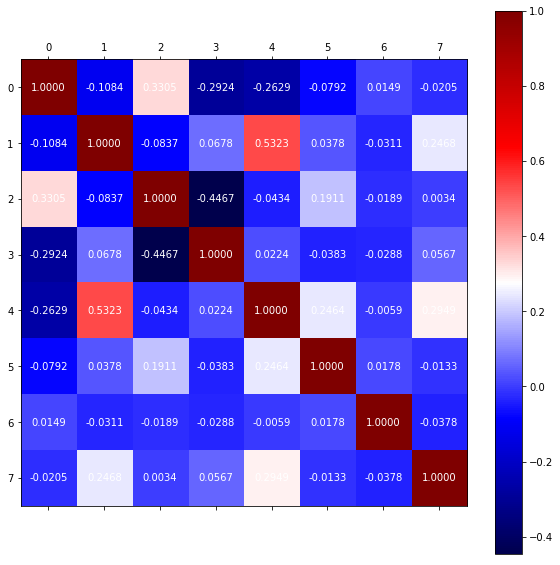

In [10]:
corr = df.corr().values
plot_corr(corr)

In [11]:
#summarize_dataset(df, samples=100)

## Learning Models

In [12]:
def learn_model(data, desc_ids, targ_ids, model, **kwargs):
    X, Y = data[:, desc_ids], data[:, targ_ids]
    
    if X.shape[1]==1: X = X.ravel()
    if Y.shape[1]==1: Y = Y.ravel()
    
    try:
        clf = model(**kwargs)
        clf.fit(X, Y)
    except ValueError as e:
        print(e)
    # Bookkeeping
    clf.desc_ids = desc_ids
    clf.targ_ids = targ_ids
    return clf

In [13]:
data = df.values

In [14]:
n,m = data.shape
print(m)
atts_ids = list(range(m))

8


## Test 01

In [15]:
df_test = pd.DataFrame(X_test)
df_test = df_test.assign(y=y_test)
test_data = df_test.values

In [16]:
targ_ids_1 = [4]
desc_ids_1 = [0,1,2,3]

targ_ids_2 = [6,7]
desc_ids_2 = [0,1,2,3,4,5]

all_desc_ids = [desc_ids_1, desc_ids_2]
all_targ_ids = [targ_ids_1, targ_ids_2]

In [17]:
m_list = []
ids = zip(all_desc_ids, all_targ_ids)
for desc_ids, targ_ids in ids:
    print(desc_ids, targ_ids)
    
    if set(targ_ids).issubset(set([6,7])):
        learner = RandomForestClassifier
    else:
        learner = RandomForestRegressor
        
    m = learn_model(data, desc_ids, targ_ids, learner, max_depth=5, n_estimators=5)
    m.desc_ids = desc_ids
    m.targ_ids = targ_ids
    m_list.append(m)

[0, 1, 2, 3] [4]
[0, 1, 2, 3, 4, 5] [6, 7]


In [18]:
sc = morpheus.SequentialComposition()

In [19]:
for m in m_list:
    sc.add_estimator(m)  

In [20]:
sc.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2. 3. 5.]
        Target attributes:          [6. 7.]

        ## On types (mostly nominals)
        Target attribute types:                     ['nominal', 'nominal']
        N_classes of nominal target attributes:     [4, 2]
        Classes of nominal target attributes:       [array([0., 1., 2., 3.]), array([0., 1.])]

        ## Weights
        Total weights of target attributes:         [1. 1.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestClassifier']
        N_estimators:           2
        


In [21]:
X = data[:,]

In [22]:
sc.nominal_targ_ids

[6.0, 7.0]

In [23]:
sc.predict(test_data[:, sc.desc_ids.astype(int)])


            e_outcome.shape:    (1, 200)
            


            e_outcome.shape:    (200, 2)
            


                t_idx_map:  [[0 0]
 [1 1]]
                



array([[1., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [2., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 1.],
       [1., 1.

In [24]:
a = np.atleast_2d([])

In [25]:
a.size

0